# Lab 3
## Kyle Walter

# MNIST Fashion Data Set

The MNIST Fashion Data Set is designed to replicate the machine learning challenge of MNIST handwritten numbers. The Data Set contains images from Zolando's collection categorized into 10 categories
0. T-Shirts
1. Trousers
2. pullovers
3. dresses
4. coats
5. Sandals
6. shirts
7. sneakers
8. bags
9. angle-boots

There are 60 thousand of each category for training data and 10 thousand images in the test. The goal of this lab is to compare a series of ML modes and decide the best on for cateogrizing the test images.

In [53]:
# Starter libraries for packages
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model Packages
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Set the path to where the files are stored
path = "/content/drive/MyDrive/Graduate School/IST718 Big Data Analysis/Lab 3/Raw Data"

In [54]:
# Labels for the Articles
# Used to make the confusion matrix easier to read
labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'angle-boot']

## Loading the Data

The data was collected from Kaggle and the images were loaded into python and convereted to data set. The images are 28 by 28 which when converted turn in to 784 columns representing the shading at each point pixel in the image.

In [55]:
# Reused formulas from class to read in the Training Data

def load_trminst(path, kind='train'):
  label_path = os.path.join(path, "train-labels-idx1-ubyte")
  image_path = os.path.join(path, "train-images-idx3-ubyte")
  with open(label_path,'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype =np.uint8)
  with open(image_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
  return images, labels

In [56]:
# Resued formula from Class to read in the Testing Data

def load_terminst(path, kind='Test'):
  label_path = os.path.join(path, "t10k-labels-idx1-ubyte")
  image_path = os.path.join(path, "t10k-images-idx3-ubyte")
  with open(label_path,'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype =np.uint8)
  with open(image_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
  return images, labels

In [57]:
# Inspect the training to see if it loaded correctly
X_train, y_train = load_trminst(path=path, kind ='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [58]:
#Inspect the Testing data to see that it loaded corrected
X_test, y_test = load_terminst(path=path, kind='Test')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


Once the data was loaded and transfomred the next step was to scale it. Many ML models preform better when the data is evenly scaled.

In [59]:
#Scale the numbers to a percentage based on 255 since that is max pixel shading. This will help the model's preform better
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

## Checking the images

The images were checked by grabbing the first image from each category and reshapping the grey space back tot the original form.

A similar check was done to see that the items that appeared in the category more closely followed what was expected for the category.

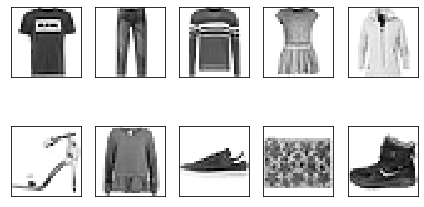

In [60]:
#Show the first image from each category
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

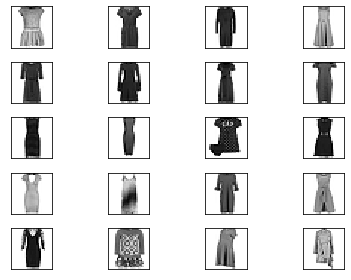

In [61]:
#Show multiple images from the 4th category they're all dresses
#but can the model learn this?
fig, ax = plt.subplots(nrows=5, ncols=4, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(20):
    img = X_train[y_train == 3][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_9.png', dpi=300)
plt.show()


# Random Forest

The first model chose was a random forest. It works by creating a number of decision trees and averaging the results amoung them to determine the category.

The main parameter for control of a random forest model is forest size. So varying sizes were tested using sklearn's GridSearchCV.

The model also chooses tree starting point based on boot strapping. So the results can be recreated, a seed of 37 was choosen so the results can be recreated.

Once these factors are fed into GridSearch it will run through each of the tree variations and find the best result. GridSearch also uses Cross validation to check how the model is likely to preform on new data by using folds and testing to build the model. The base form of the equation uses 5 fold cross validation and this wasn't changed as there is a test set to try against.

In [62]:
#Random Forest Classifier
#Sets the paramenters the grid search
parameters = {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}
rndForest = RandomForestClassifier(random_state=37)
rnd_clf = GridSearchCV(rndForest, param_grid=parameters)
%time rnd_clf.fit(X_train, y_train)

CPU times: user 34min 36s, sys: 2.45 s, total: 34min 38s
Wall time: 34min 37s


GridSearchCV(estimator=RandomForestClassifier(random_state=37),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]})

The model takes quite a long time run when using grid search, around 35 minutes. The best result was 100 trees and returned an averge accuracy score of 88.19%

The results of all the runs can be seen in the table below

In [63]:
#Data Table showing the runs from the Gridsearch to find the optimum forest size
pd.DataFrame(rnd_clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.193654,0.026203,0.068161,0.000461,10,{'n_estimators': 10},0.855000,0.856083,0.861583,0.862500,0.858333,0.858700,0.002947,10
1,14.293998,0.069755,0.125610,0.001197,20,{'n_estimators': 20},0.870917,0.864667,0.873750,0.872667,0.869167,0.870233,0.003190,9
2,21.457303,0.124496,0.185375,0.007336,30,{'n_estimators': 30},0.875500,0.869083,0.877417,0.878667,0.874000,0.874933,0.003332,8
3,28.678644,0.110079,0.243198,0.002523,40,{'n_estimators': 40},0.878750,0.871833,0.882417,0.881833,0.875333,0.878033,0.003997,7
4,35.712464,0.171982,0.289737,0.003282,50,{'n_estimators': 50},0.879167,0.872083,0.884167,0.880917,0.877750,0.878817,0.003991,6
5,42.960984,0.107973,0.353411,0.003544,60,{'n_estimators': 60},0.877833,0.872167,0.885417,0.881917,0.879750,0.879417,0.004414,5
6,50.306263,0.170580,0.412216,0.004855,70,{'n_estimators': 70},0.879583,0.875000,0.885500,0.883583,0.879167,0.880567,0.003670,4
7,57.615932,0.096638,0.479068,0.010710,80,{'n_estimators': 80},0.881333,0.875583,0.885083,0.884250,0.881167,0.881483,0.003333,3
8,64.421371,0.389280,0.528816,0.007784,90,{'n_estimators': 90},0.880917,0.876250,0.886333,0.885250,0.880000,0.881750,0.003668,2
9,71.101242,0.314974,0.569128,0.002159,100,{'n_estimators': 100},0.881500,0.876333,0.885917,0.886083,0.879667,0.881900,0.003735,1


Here is the classification report for the the Random forest model after a prediction is done on the test data. The model preforms with 87.53% accuracy and a small loss in fidelity is often expected when being introduced to new data.

The F1 scores indicate the model has some difficulty with Shirts, Coats, and Pullovers

In [64]:
#Classification Report of the best
y_pred = rnd_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

           0    0.81853   0.85700   0.83732      1000
           1    0.99482   0.96100   0.97762      1000
           2    0.76381   0.80200   0.78244      1000
           3    0.87380   0.90700   0.89009      1000
           4    0.77003   0.81700   0.79282      1000
           5    0.97646   0.95400   0.96510      1000
           6    0.71585   0.58700   0.64505      1000
           7    0.92159   0.95200   0.93655      1000
           8    0.95764   0.97200   0.96476      1000
           9    0.95065   0.94400   0.94732      1000

    accuracy                        0.87530     10000
   macro avg    0.87432   0.87530   0.87391     10000
weighted avg    0.87432   0.87530   0.87391     10000



Here is confusion matrix output. It appears most of the miss classification result in the model selecting shirts.

Text(33.0, 0.5, 'Prediction')

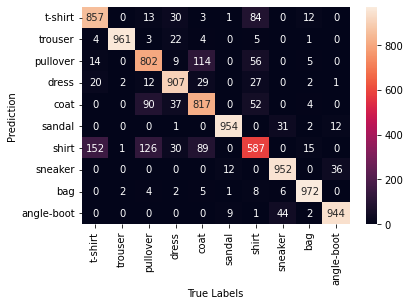

In [65]:
#Confusion Matrix Heatmap
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('True Labels')
plt.ylabel('Prediction')

# Gaussian Naive Bayes Model

The second model tried was Gaussian Naive Bayes Modesl. Naive Bayes converges quite quickly, however; while it can be utlized for multi class, it usually preforms best with Binary.

The Model converged below in less than 1 second, however it has a number of the categories that is preforming quite poorly when comparing it's predictions to the test data. It also cannot correctly classify shirts above a random guess.

In [66]:
#Naive Bayes Gausian Model
nb_clf = GaussianNB()
%time nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

CPU times: user 312 ms, sys: 935 µs, total: 313 ms
Wall time: 313 ms
              precision    recall  f1-score   support

           0    0.81389   0.58600   0.68140      1000
           1    0.63704   0.93900   0.75909      1000
           2    0.58909   0.32400   0.41806      1000
           3    0.44454   0.54500   0.48967      1000
           4    0.37669   0.77900   0.50782      1000
           5    0.92667   0.27800   0.42769      1000
           6    0.32000   0.04000   0.07111      1000
           7    0.50511   0.98800   0.66847      1000
           8    0.83333   0.71000   0.76674      1000
           9    0.91495   0.66700   0.77154      1000

    accuracy                        0.58560     10000
   macro avg    0.63613   0.58560   0.55616     10000
weighted avg    0.63613   0.58560   0.55616     10000



Text(33.0, 0.5, 'Prediction')

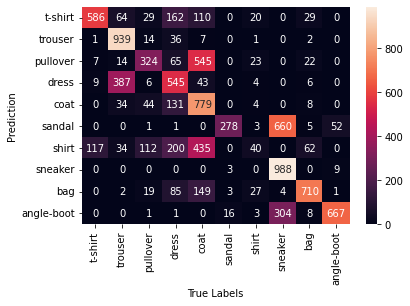

In [67]:
#Confusion Matrix Heatmap
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('True Labels')
plt.ylabel('Prediction')

# Neural Network Model

Neural networks are in a bit of hay day. They tend to preform well at more complex task and able to break up the data in multiple levels of learning. Like decision trees they can easily overfit the model.

For this run left most of the base structure in place. It has a learn rate of 0.001. The model did complain about being able to converge at the base setting of 200 itterations, so matching the class model went up to 1,000 iterations and model was able to converge.

The model shows better results in F1 scores for all categories than the Decision tree although only slightly better on the shirts. Along with the highest accuracy against the testing data, although only slightly better.

The model also is in the middle for conversion time around 9 minutes and 38 seconds. And an Accuracy of 88.25%

In [68]:
# Nueral Network
nn_clf = MLPClassifier(max_iter=1000)
%time nn_clf.fit(X_train, y_train)
y_pred = nn_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=5))

CPU times: user 6min 21s, sys: 3min 16s, total: 9min 38s
Wall time: 4min 52s
              precision    recall  f1-score   support

           0    0.79409   0.86000   0.82573      1000
           1    0.98774   0.96700   0.97726      1000
           2    0.78257   0.81700   0.79941      1000
           3    0.89666   0.85900   0.87743      1000
           4    0.82103   0.81200   0.81649      1000
           5    0.97452   0.95600   0.96517      1000
           6    0.72487   0.68500   0.70437      1000
           7    0.91996   0.97700   0.94762      1000
           8    0.96479   0.95900   0.96189      1000
           9    0.96684   0.93300   0.94962      1000

    accuracy                        0.88250     10000
   macro avg    0.88331   0.88250   0.88250     10000
weighted avg    0.88331   0.88250   0.88250     10000



Text(33.0, 0.5, 'Prediction')

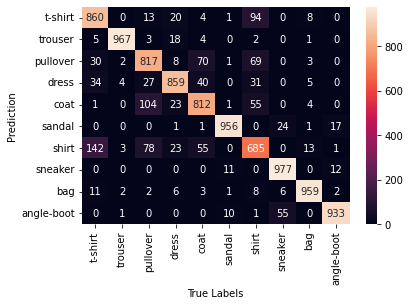

In [69]:
#Confusion Matrix Heatmap
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('True Labels')
plt.ylabel('Prediction')

# Conclusion

Based on the three models test the Neural Nework would be the best option. While it takes around 10 minutes to converge, it showed the highest accuracy with the testing, and per the documentation from sklearn it will stop once an convergence is met.

Random Forest may be able to achieve a higher accuracy but to get close to what the Neural Network is doing took over 35 minutes so additional time to test the Forest Size may prove to be too long. 

The Gaussian Model is by far the fastest to converge, however; it fail to classify one of the categories above random guess. So while over all the model preforms well when introduced to new information it shows unrelable results.